In [ ]:
import sys
sys.path.insert(0, "../..")
from paths import FIG_DIR
from graphvelo.graph_velocity import GraphVelo
from graphvelo.metrics import cross_boundary_correctness

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
adata = sc.read('mouse_ery_gv.h5ad')
adata

AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'mack_score'
    uns: 'celltype_colors', 'gv_params', 'log1p', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'gv_pca', 'gv_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 'f

In [3]:
edges = [['Blood progenitors 1', 'Blood progenitors 2'], ['Blood progenitors 2', 'Erythroid1'], ['Erythroid1', 'Erythroid2'], ['Erythroid2', 'Erythroid3']]

In [4]:
def permute_velo(V):
    np.random.seed(0)
    plmi = np.array([+1, -1])
    for i in range(V.shape[1]):
        np.random.shuffle(V[:, i])
        V[:, i] = V[:, i] * np.random.choice(plmi, size=V.shape[0])

In [5]:
sim = []
dist = []
ns = np.linspace(100, 450, 8, dtype=int)
mask = adata.var['velocity_genes'].values
score_list = []
for n in ns:
    print("-----------------------------")
    print(f"Train GraphVelo with top {n} mack genes.")

    gene_subset = adata.var['mack_score'].sort_values(ascending=False)[:n].index.to_list()
    gv = GraphVelo(adata, gene_subset=gene_subset)
    gv.train()
    adata.layers['velocity_gv'] = gv.project_velocity(adata.layers['Ms'])
    cbc = cross_boundary_correctness(adata, cluster_key='celltype', cluster_edges=edges, xkey='Ms', vkey='velocity_gv', basis='raw',  return_raw=True)
    score = np.array([j for i in cbc.values() for j in i])
    score_list.append(score)

cbc = cross_boundary_correctness(adata, cluster_key='celltype', cluster_edges=edges, xkey='Ms', vkey='velocity', basis='raw',  return_raw=True)
score = np.array([j for i in cbc.values() for j in i])
score_list.append(score)

adata.layers['velocity_rnd'] = adata.layers['velocity'].copy()
permute_velo(adata.layers['velocity_rnd'])
cbc = cross_boundary_correctness(adata, cluster_key='celltype', cluster_edges=edges, xkey='Ms', vkey='velocity_rnd', basis='raw',  return_raw=True)
score = np.array([j for i in cbc.values() for j in i])
score_list.append(score)

-----------------------------
Train GraphVelo with top 100 mack genes.


Learning Phi in tangent space projection.: 100%|██████████| 9815/9815 [00:07<00:00, 1306.23it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:03<00:00, 3136.49it/s]


-----------------------------
Train GraphVelo with top 150 mack genes.


Learning Phi in tangent space projection.: 100%|██████████| 9815/9815 [00:04<00:00, 2061.77it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:02<00:00, 4464.95it/s]


-----------------------------
Train GraphVelo with top 200 mack genes.


Learning Phi in tangent space projection.: 100%|██████████| 9815/9815 [00:05<00:00, 1938.21it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:02<00:00, 3807.56it/s]


-----------------------------
Train GraphVelo with top 250 mack genes.


Learning Phi in tangent space projection.: 100%|██████████| 9815/9815 [00:05<00:00, 1879.77it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:02<00:00, 4318.09it/s]


-----------------------------
Train GraphVelo with top 300 mack genes.


Learning Phi in tangent space projection.: 100%|██████████| 9815/9815 [00:05<00:00, 1823.74it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:02<00:00, 4376.31it/s]


-----------------------------
Train GraphVelo with top 350 mack genes.


Learning Phi in tangent space projection.: 100%|██████████| 9815/9815 [00:05<00:00, 1781.93it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:02<00:00, 4080.51it/s]


-----------------------------
Train GraphVelo with top 400 mack genes.


Learning Phi in tangent space projection.: 100%|██████████| 9815/9815 [00:05<00:00, 1824.93it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:02<00:00, 4636.49it/s]


-----------------------------
Train GraphVelo with top 450 mack genes.


Learning Phi in tangent space projection.: 100%|██████████| 9815/9815 [00:06<00:00, 1566.52it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:02<00:00, 3366.14it/s]


In [6]:
cbc_df = pd.DataFrame(
    np.vstack((
        score_list
    )).T, columns=ns.tolist()+['scVelo', 'random']
)

In [7]:
cbc_df_mlt = cbc_df.melt()
cbc_df_mlt.columns = ['n_top_genes', 'CBC score']

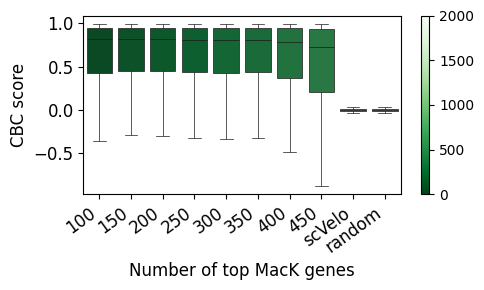

In [8]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

cmap = plt.get_cmap('Greens_r')
norm = mcolors.Normalize(vmin=0, vmax=2000)

# Build a palette dictionary mapping each group to a hex color.
# The mean values are normalized to [0,1] and then mapped to a color.
palette_dict = {}
for n in ns:
    rgba = cmap(norm(n))
    palette_dict[str(n)] = mcolors.to_hex(rgba)

palette_dict['scVelo'] = 'grey'
palette_dict['random'] = 'grey'

# Create the figure and boxplot using the computed palette
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
sns.boxplot(
    x="n_top_genes", 
    y="CBC score", 
    data=cbc_df_mlt, 
    ax=ax, 
    linewidth=0.5, 
    showfliers=False,
    palette=palette_dict
)

sm = cm.ScalarMappable(norm=norm, cmap='Greens_r')
cbar = plt.colorbar(sm, ax=ax)

ax.set_xlabel('Number of top MacK genes', fontsize=12)
plt.xticks(rotation=36, ha='right', fontsize=12)
plt.yticks([-0.5, 0, 0.5, 1], fontsize=12)
plt.ylabel('CBC score', fontsize=12)

plt.tight_layout()
plt.savefig(str(FIG_DIR)+'/suppl_figures_mouse_ery/compare_top_mack.pdf', dpi=300, transparent=True)
plt.show()